# 'MassGenie' data preparation pipeline

 - download data from ZINC database
 - ?clean it from multiple legends and xml shit tha might occur?
 - canonicalize the smiles and add the canonical column
 - remove duplicates
 - remove samples with SMILES longer than 99
 - generate spectra for them

 filtering:
     - remove samples with MZs exceeding 500
     - remove samples with more than 100 peaks

6

In [32]:
!pip install transformers    # pred upgradem: 4.17.0
!pwd

Defaulting to user installation because normal site-packages is not writeable
/auto/brno6/home/ahajek/Spektro/MassGenie/data


In [12]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import os
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.inchi import MolToInchiKey

In [8]:
# BACHA PREPISE DATA

# data_path = "trial_set/8M.smi"
# data_path_clean = "trial_set/1K_clean.smi"
# with open(data_path, "r") as dirty, open(data_path_clean, "w") as clean:
#     clean.write("smiles zinc_id\n")
#     for line in dirty:
#         if line[0] == "s" or line[0] == "<":
#             continue
#         else:
#             clean.write(line)
# os.remove(data_path)
# os.rename(data_path_clean, data_path)

In [9]:
df = pd.read_csv(data_path, sep=" ")

In [10]:
df

,smiles,zinc_id
0,CO[C@H]1OC[C@@H](O)[C@H](O)[C@H]1O,4371221
1,NC(=O)N[C@@H]1NC(=O)NC1=O,1843030
2,NC(=O)CN1CCC(N)CC1,9256947
3,CNC(=O)c1n[nH]c(N)n1,19844301
4,NC(=O)[C@H]1[C@H]2C=C[C@@H](O2)[C@@H]1N,242677143
...,...,...
11722567,COc1cc(/C=C2\SC(=S)N(c3cccc(C(F)(F)F)c3)C2=O)c...,409352639
11722568,COc1cc(/C=C2/SC(=S)N(NC(=O)Nc3ccc(Cl)c(Cl)c3)C...,409369685
11722569,CCOc1cc(/C=C2\C(=O)NC(=S)N(c3ccc(CC)cc3)C2=O)c...,409380109
11722570,CCCC[C@H](CC)CN1C(=O)C2=C(c3ccc([Sn](C)(C)C)s3...,514278552


In [17]:
df.loc[df['smiles'].str.len() > 150]

,smiles,zinc_id
1538581,C[C@@H]1[C@@]23[C@H]4[C@@H]5[C@@H]6[C@@H]7[C@@...,257355993
1603626,C[C@H]1[C@]23[C@@H]4[C@H]5[C@H]6[C@@H]7[C@H]8[...,257355994
4790593,c1ccc([C@@H]2[C@]34[C@H]5[C@@H]6[C@@H]7[C@@H]8...,257357227
4791548,c1ccc([C@]23[C@H]4[C@H]5[C@@H]6[C@@H]7[C@@H]8[...,257355613
4803857,c1ccc([C@@]23[C@H]4[C@H]5[C@@H]6[C@@H]7[C@@H]8...,257355616
...,...,...
11635216,COC(=O)CCC[C@@]1(c2ccccc2)[C@]23c4c5c6c7c8c9c(...,247835382
11636894,O=C1[C@H]2ON(c3ccccc3)[C@@H](c3ccc([N+](=O)[O-...,150434274
11637016,CO[C@@H]1/C=C/O[C@]2(C)Oc3c(C)c(O)c4c(O)c(c5c(...,584577135
11638921,CO[C@@H]1/C=C\O[C@@]2(C)Oc3c(C)c(O)c4c(O)c(c5c...,504276152


### Canonicalization or whatever

Comparing speed of different methods of SMILES canonicalization

In [18]:
len([smi for smi in df["smiles"]])

11722572

#### RDKit

In [19]:
%%time
cans = [Chem.MolToSmiles(Chem.MolFromSmiles(smi),True) for smi in df["smiles"]]

RDKit WARNING: [22:28:50] Conflicting single bond directions around double bond at index 16.
RDKit WARNING: [22:28:50]   BondStereo set to STEREONONE and single bond directions set to NONE.


CPU times: user 41min 51s, sys: 2.6 s, total: 41min 54s
Wall time: 41min 54s


In [20]:
df_canon = df.copy()
df_canon["canon_smiles"] = cans
df_canon = df_canon[["zinc_id", "smiles", "canon_smiles"]]
df_canon

,zinc_id,smiles,canon_smiles
0,4371221,CO[C@H]1OC[C@@H](O)[C@H](O)[C@H]1O,CO[C@H]1OC[C@@H](O)[C@H](O)[C@H]1O
1,1843030,NC(=O)N[C@@H]1NC(=O)NC1=O,NC(=O)N[C@@H]1NC(=O)NC1=O
2,9256947,NC(=O)CN1CCC(N)CC1,NC(=O)CN1CCC(N)CC1
3,19844301,CNC(=O)c1n[nH]c(N)n1,CNC(=O)c1n[nH]c(N)n1
4,242677143,NC(=O)[C@H]1[C@H]2C=C[C@@H](O2)[C@@H]1N,NC(=O)[C@H]1[C@H]2C=C[C@@H](O2)[C@@H]1N
...,...,...,...
11722567,409352639,COc1cc(/C=C2\SC(=S)N(c3cccc(C(F)(F)F)c3)C2=O)c...,COc1cc(/C=C2\SC(=S)N(c3cccc(C(F)(F)F)c3)C2=O)c...
11722568,409369685,COc1cc(/C=C2/SC(=S)N(NC(=O)Nc3ccc(Cl)c(Cl)c3)C...,COc1cc(/C=C2/SC(=S)N(NC(=O)Nc3ccc(Cl)c(Cl)c3)C...
11722569,409380109,CCOc1cc(/C=C2\C(=O)NC(=S)N(c3ccc(CC)cc3)C2=O)c...,CCOc1cc(/C=C2\C(=O)NC(=S)N(c3ccc(CC)cc3)C2=O)c...
11722570,514278552,CCCC[C@H](CC)CN1C(=O)C2=C(c3ccc([Sn](C)(C)C)s3...,CCCC[C@H](CC)CN1C(=O)C2=C(c3ccc([Sn](C)(C)C)s3...


In [ ]:
df_canon.loc[df_canon['smiles'].str.len() > 150]

### Deduplication

In [9]:
df_dedup = df_canon.copy().drop_duplicates(subset=["canon_smiles"])

In [10]:
df_dedup

,zinc_id,smiles,canon_smiles
0,65423162,Cc1nn(C)c(C)c1S(=O)(=O)N1CCN2C(=O)CN(C)C(=O)[C...,Cc1nn(C)c(C)c1S(=O)(=O)N1CCN2C(=O)CN(C)C(=O)[C...
1,91985397,O=C(CN1C(=O)CNC1=O)N1C[C@@H](CO)C[C@H](CN2CCOC...,O=C(CN1C(=O)CNC1=O)N1C[C@@H](CO)C[C@H](CN2CCOC...
2,239433518,CC(=O)Nc1ccc(O[C@@H]2O[C@H](CO)[C@H](O)[C@H](O...,CC(=O)Nc1ccc(O[C@@H]2O[C@H](CO)[C@H](O)[C@H](O...
3,245377209,CC(=O)Nc1ccccc1O[C@@H]1O[C@H](CO)[C@H](O)[C@@H...,CC(=O)Nc1ccccc1O[C@@H]1O[C@H](CO)[C@H](O)[C@@H...
4,253471034,O=C(CNS(=O)(=O)c1cccc(F)c1)N1CC(N2C(=O)CNC2=O)C1,O=C(CNS(=O)(=O)c1cccc(F)c1)N1CC(N2C(=O)CNC2=O)C1
...,...,...,...
994,9307887,CN(CCO)CCC(=O)N[C@@]1(C)CS(=O)(=O)C[C@@H]1S(=O...,CN(CCO)CCC(=O)N[C@@]1(C)CS(=O)(=O)C[C@@H]1S(=O...
995,575441396,OCCOCCOCCOCCNCCOCCOCCOCCO,OCCOCCOCCOCCNCCOCCOCCOCCO
996,8738368,CC(=O)O[C@@H]1C(=O)O[C@@H]2[C@@H]1O[C@H](n1ccc...,CC(=O)O[C@@H]1C(=O)O[C@@H]2[C@@H]1O[C@H](n1ccc...
997,886071806,Cn1c(CN2CCN([C@@]3(C(=O)O)CCOC3)CC2)cc(=O)n(C)...,Cn1c(CN2CCN([C@@]3(C(=O)O)CCOC3)CC2)cc(=O)n(C)...


### Filter long canonical SMILES

In [11]:
# filter canonical SMILES strings longer than 99
df_shortS = df_dedup.copy().loc[df_dedup['canon_smiles'].str.len() < 99]

In [12]:
df_shortS

,zinc_id,smiles,canon_smiles
0,65423162,Cc1nn(C)c(C)c1S(=O)(=O)N1CCN2C(=O)CN(C)C(=O)[C...,Cc1nn(C)c(C)c1S(=O)(=O)N1CCN2C(=O)CN(C)C(=O)[C...
1,91985397,O=C(CN1C(=O)CNC1=O)N1C[C@@H](CO)C[C@H](CN2CCOC...,O=C(CN1C(=O)CNC1=O)N1C[C@@H](CO)C[C@H](CN2CCOC...
2,239433518,CC(=O)Nc1ccc(O[C@@H]2O[C@H](CO)[C@H](O)[C@H](O...,CC(=O)Nc1ccc(O[C@@H]2O[C@H](CO)[C@H](O)[C@H](O...
3,245377209,CC(=O)Nc1ccccc1O[C@@H]1O[C@H](CO)[C@H](O)[C@@H...,CC(=O)Nc1ccccc1O[C@@H]1O[C@H](CO)[C@H](O)[C@@H...
4,253471034,O=C(CNS(=O)(=O)c1cccc(F)c1)N1CC(N2C(=O)CNC2=O)C1,O=C(CNS(=O)(=O)c1cccc(F)c1)N1CC(N2C(=O)CNC2=O)C1
...,...,...,...
994,9307887,CN(CCO)CCC(=O)N[C@@]1(C)CS(=O)(=O)C[C@@H]1S(=O...,CN(CCO)CCC(=O)N[C@@]1(C)CS(=O)(=O)C[C@@H]1S(=O...
995,575441396,OCCOCCOCCOCCNCCOCCOCCOCCO,OCCOCCOCCOCCNCCOCCOCCOCCO
996,8738368,CC(=O)O[C@@H]1C(=O)O[C@@H]2[C@@H]1O[C@H](n1ccc...,CC(=O)O[C@@H]1C(=O)O[C@@H]2[C@@H]1O[C@H](n1ccc...
997,886071806,Cn1c(CN2CCN([C@@]3(C(=O)O)CCOC3)CC2)cc(=O)n(C)...,Cn1c(CN2CCN([C@@]3(C(=O)O)CCOC3)CC2)cc(=O)n(C)...


### Save/Load the filtered SMILES

In [13]:
# save
df_shortS.to_pickle("./trial_set/filtered_smiles.pkl")

In [14]:
# load
df_shortS = pd.read_pickle("./trial_set/filtered_smiles.pkl")

### Generate spectra

In [15]:
df_test = df_shortS[:10000]
df_test

,zinc_id,smiles,canon_smiles
0,65423162,Cc1nn(C)c(C)c1S(=O)(=O)N1CCN2C(=O)CN(C)C(=O)[C...,Cc1nn(C)c(C)c1S(=O)(=O)N1CCN2C(=O)CN(C)C(=O)[C...
1,91985397,O=C(CN1C(=O)CNC1=O)N1C[C@@H](CO)C[C@H](CN2CCOC...,O=C(CN1C(=O)CNC1=O)N1C[C@@H](CO)C[C@H](CN2CCOC...
2,239433518,CC(=O)Nc1ccc(O[C@@H]2O[C@H](CO)[C@H](O)[C@H](O...,CC(=O)Nc1ccc(O[C@@H]2O[C@H](CO)[C@H](O)[C@H](O...
3,245377209,CC(=O)Nc1ccccc1O[C@@H]1O[C@H](CO)[C@H](O)[C@@H...,CC(=O)Nc1ccccc1O[C@@H]1O[C@H](CO)[C@H](O)[C@@H...
4,253471034,O=C(CNS(=O)(=O)c1cccc(F)c1)N1CC(N2C(=O)CNC2=O)C1,O=C(CNS(=O)(=O)c1cccc(F)c1)N1CC(N2C(=O)CNC2=O)C1
...,...,...,...
994,9307887,CN(CCO)CCC(=O)N[C@@]1(C)CS(=O)(=O)C[C@@H]1S(=O...,CN(CCO)CCC(=O)N[C@@]1(C)CS(=O)(=O)C[C@@H]1S(=O...
995,575441396,OCCOCCOCCOCCNCCOCCOCCOCCO,OCCOCCOCCOCCNCCOCCOCCOCCO
996,8738368,CC(=O)O[C@@H]1C(=O)O[C@@H]2[C@@H]1O[C@H](n1ccc...,CC(=O)O[C@@H]1C(=O)O[C@@H]2[C@@H]1O[C@H](n1ccc...
997,886071806,Cn1c(CN2CCN([C@@]3(C(=O)O)CCOC3)CC2)cc(=O)n(C)...,Cn1c(CN2CCN([C@@]3(C(=O)O)CCOC3)CC2)cc(=O)n(C)...


In [21]:
%%time
def filter_corrupted_smiles(pp):
    for index, row in pp.iterrows():
#         print(row["canon_smiles"])
#         try:
#             mol = Chem.MolFromSmiles(row["canon_smiles"])
#         except:
#             pp.drop(index, inplace=True)

        if not Chem.MolFromSmiles(row["canon_smiles"]): # nefungovalo, tak sem nahradil destereo za canon
            df.drop(index, inplace=True)
    print("after filtering corrupted molecules:", len(pp))
    return pp

sdf_before = "/storage/projects/msml/mg_neims_branch/MassGenie/data/trial_set/tmp/filtered_before.sdf"
sdf_after = "/storage/projects/msml/mg_neims_branch/MassGenie/data/trial_set/tmp/enriched_smiles.sdf"
model_weights = "../NEIMS/NEIMS_weights"

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.87 µs


In [22]:
%%time
PandasTools.AddMoleculeColumnToFrame(df_test, smilesCol='canon_smiles', molCol='ROMol')

CPU times: user 132 ms, sys: 11.4 ms, total: 143 ms
Wall time: 193 ms


In [23]:
# df_test.drop(columns="smiles")
# df_test.drop_duplicates(subset=["canon_smiles"])

In [24]:
%%time
# pp = pp.assign(inchikey=lambda x: [MolToInchiKey(mol) for mol in x["ROMol"]])#.set_index("ID")
df_test = filter_corrupted_smiles(df_test)

# filter pp to unique according to inchikey
# pp = pp.drop_duplicates(subset=["inchikey"])

after filtering corrupted molecules: 999
CPU times: user 187 ms, sys: 0 ns, total: 187 ms
Wall time: 187 ms


In [25]:
%%time
PandasTools.WriteSDF(df_test, sdf_before, idName="zinc_id", properties=list(df_test.columns))

print(f"now run add_conda_NEIMSpy2.sh and then:\n###############\n bash /storage/projects/msml/mg_neims_branch/NEIMS/run_make_spectra_prediction.sh {sdf_before} {sdf_after} && conda deactivate\n###############\n")

now run add_conda_NEIMSpy2.sh and then:
###############
 bash /storage/projects/msml/mg_neims_branch/NEIMS/run_make_spectra_prediction.sh /storage/projects/msml/mg_neims_branch/MassGenie/data/trial_set/tmp/filtered_before.sdf /storage/projects/msml/mg_neims_branch/MassGenie/data/trial_set/tmp/enriched_smiles.sdf && conda deactivate
###############

CPU times: user 371 ms, sys: 8.92 ms, total: 380 ms
Wall time: 491 ms


### Load Generated spectra, process, normalize

,smiles,canon smiles,PREDICTED SPECTRUM,zinc_id,Molecule
0,Cc1nn(C)c(C)c1S(=O)(=O)N1CCN2C(=O)CN(C)C(=O)[C...,Cc1nn(C)c(C)c1S(=O)(=O)N1CCN2C(=O)CN(C)C(=O)[C...,33 38\n34 36\n38 11\n39 184\n40 230\n41 317\n4...,65423162,
1,O=C(CN1C(=O)CNC1=O)N1C[C@@H](CO)C[C@H](CN2CCOC...,O=C(CN1C(=O)CNC1=O)N1C[C@@H](CO)C[C@H](CN2CCOC...,2 3\n30 22\n33 45\n34 29\n36 37\n38 29\n39 163...,91985397,
2,CC(=O)Nc1ccc(O[C@@H]2O[C@H](CO)[C@H](O)[C@H](O...,CC(=O)Nc1ccc(O[C@@H]2O[C@H](CO)[C@H](O)[C@H](O...,14 38\n15 63\n16 25\n17 45\n18 64\n19 1\n25 37...,239433518,
3,CC(=O)Nc1ccccc1O[C@@H]1O[C@H](CO)[C@H](O)[C@@H...,CC(=O)Nc1ccccc1O[C@@H]1O[C@H](CO)[C@H](O)[C@@H...,14 35\n15 84\n16 13\n17 45\n18 55\n19 26\n25 3...,245377209,
4,O=C(CNS(=O)(=O)c1cccc(F)c1)N1CC(N2C(=O)CNC2=O)C1,O=C(CNS(=O)(=O)c1cccc(F)c1)N1CC(N2C(=O)CNC2=O)C1,33 54\n38 4\n39 160\n40 121\n41 210\n42 355\n4...,253471034,
...,...,...,...,...,...
9995,NC(=O)CCNC(=O)c1cccc(S(=O)(=O)N2CCNC(=O)C2)c1,NC(=O)CCNC(=O)c1cccc(S(=O)(=O)N2CCNC(=O)C2)c1,33 38\n34 5\n38 58\n39 234\n40 137\n41 225\n42...,465135474,
9996,COC(=O)[C@H]1CNC(=O)CN1C(=O)c1ccc(=O)n(-c2cnn(...,COC(=O)[C@H]1CNC(=O)CN1C(=O)c1ccc(=O)n(-c2cnn(...,33 78\n38 148\n39 713\n40 346\n41 434\n42 742\...,468641331,
9997,C[C@H]1CN(C(=O)C(=O)Nc2cnn(CC(=O)N3CCOCC3)c2)CCO1,C[C@H]1CN(C(=O)C(=O)Nc2cnn(CC(=O)N3CCOCC3)c2)CCO1,33 58\n34 20\n36 24\n37 76\n38 145\n39 379\n40...,485104689,
9998,COC(=O)[C@](C)(O)CNC(=O)CCN1C(=O)[C@@H]2[C@H]3...,COC(=O)[C@](C)(O)CNC(=O)CCN1C(=O)[C@@H]2[C@H]3...,14 33\n15 144\n16 29\n17 49\n18 92\n19 8\n25 6...,485509289,

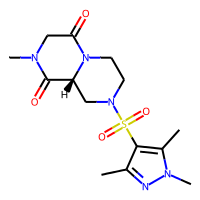
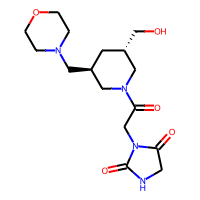
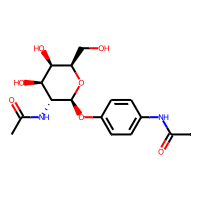
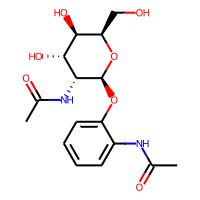
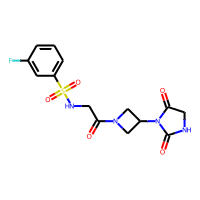
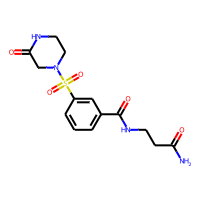
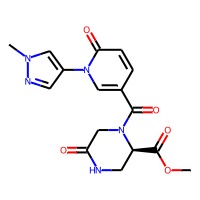
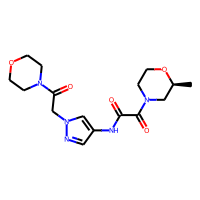
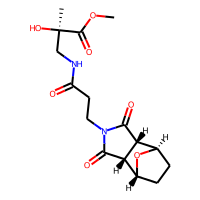
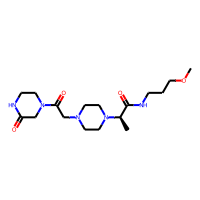

In [12]:
df_gen

In [7]:
%%time
df_gen = PandasTools.LoadSDF(sdf_after, idName="zinc_id", molColName='Molecule')

CPU times: user 6.16 s, sys: 135 ms, total: 6.29 s
Wall time: 6.29 s


In [8]:
na = np.array([1,2,3])
na/max(na)

array([0.33333333, 0.66666667, 1.        ])

In [9]:
%%time

# processing spectra to be in a reasonable format
def process_spec(df):
    df2 = df.copy()
    new_df = pd.DataFrame()
    all_i = []
    all_mz = []
    for row in range(len(df2)):
        spec = df2["PREDICTED SPECTRUM"][row].split("\n")
        mz = []
        i = []
        spec_max = 0
        for t in spec:
            j,d = t.split()
            j,d = int(j), float(d)
            if spec_max < d:
                spec_max  = d
            mz.append(j)
            i.append(d)
        all_mz.append(mz)
        all_i.append(np.around(np.array(i)/spec_max, 2))
    new_df = DataFrame.from_dict({"mz": all_mz, "intensity": all_i})
    df2 = pd.concat([df2, new_df], axis=1)
    df2 = df2.drop(["PREDICTED SPECTRUM"], axis=1)
    return df2

df_gen_mzi = process_spec(df_gen)

CPU times: user 1.35 s, sys: 19.8 ms, total: 1.37 s
Wall time: 1.36 s


,smiles,canon smiles,zinc_id,Molecule,mz,intensity
0,Cc1nn(C)c(C)c1S(=O)(=O)N1CCN2C(=O)CN(C)C(=O)[C...,Cc1nn(C)c(C)c1S(=O)(=O)N1CCN2C(=O)CN(C)C(=O)[C...,65423162,,"[33, 34, 38, 39, 40, 41, 42, 43, 44, 45, 48, 5...","[0.04, 0.04, 0.01, 0.18, 0.23, 0.32, 1.0, 0.17..."
1,O=C(CN1C(=O)CNC1=O)N1C[C@@H](CO)C[C@H](CN2CCOC...,O=C(CN1C(=O)CNC1=O)N1C[C@@H](CO)C[C@H](CN2CCOC...,91985397,,"[2, 30, 33, 34, 36, 38, 39, 40, 41, 42, 43, 44...","[0.0, 0.02, 0.05, 0.03, 0.04, 0.03, 0.16, 0.12..."
2,CC(=O)Nc1ccc(O[C@@H]2O[C@H](CO)[C@H](O)[C@H](O...,CC(=O)Nc1ccc(O[C@@H]2O[C@H](CO)[C@H](O)[C@H](O...,239433518,,"[14, 15, 16, 17, 18, 19, 25, 26, 27, 28, 29, 3...","[0.04, 0.06, 0.03, 0.05, 0.06, 0.0, 0.04, 0.09..."
3,CC(=O)Nc1ccccc1O[C@@H]1O[C@H](CO)[C@H](O)[C@@H...,CC(=O)Nc1ccccc1O[C@@H]1O[C@H](CO)[C@H](O)[C@@H...,245377209,,"[14, 15, 16, 17, 18, 19, 25, 26, 27, 28, 29, 3...","[0.04, 0.08, 0.01, 0.05, 0.06, 0.03, 0.03, 0.0..."
4,O=C(CNS(=O)(=O)c1cccc(F)c1)N1CC(N2C(=O)CNC2=O)C1,O=C(CNS(=O)(=O)c1cccc(F)c1)N1CC(N2C(=O)CNC2=O)C1,253471034,,"[33, 38, 39, 40, 41, 42, 43, 44, 45, 48, 50, 5...","[0.05, 0.0, 0.16, 0.12, 0.21, 0.36, 0.1, 0.21,..."
...,...,...,...,...,...,...
9995,NC(=O)CCNC(=O)c1cccc(S(=O)(=O)N2CCNC(=O)C2)c1,NC(=O)CCNC(=O)c1cccc(S(=O)(=O)N2CCNC(=O)C2)c1,465135474,,"[33, 34, 38, 39, 40, 41, 42, 43, 44, 45, 46, 4...","[0.04, 0.01, 0.06, 0.23, 0.14, 0.23, 0.82, 0.5..."
9996,COC(=O)[C@H]1CNC(=O)CN1C(=O)c1ccc(=O)n(-c2cnn(...,COC(=O)[C@H]1CNC(=O)CN1C(=O)c1ccc(=O)n(-c2cnn(...,468641331,,"[33, 38, 39, 40, 41, 42, 43, 44, 45, 50, 51, 5...","[0.08, 0.15, 0.71, 0.35, 0.43, 0.74, 0.11, 0.0..."
9997,C[C@H]1CN(C(=O)C(=O)Nc2cnn(CC(=O)N3CCOCC3)c2)CCO1,C[C@H]1CN(C(=O)C(=O)Nc2cnn(CC(=O)N3CCOCC3)c2)CCO1,485104689,,"[33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 4...","[0.06, 0.02, 0.02, 0.08, 0.15, 0.38, 0.28, 0.4..."
9998,COC(=O)[C@](C)(O)CNC(=O)CCN1C(=O)[C@@H]2[C@H]3...,COC(=O)[C@](C)(O)CNC(=O)CCN1C(=O)[C@@H]2[C@H]3...,485509289,,"[14, 15, 16, 17, 18, 19, 25, 26, 27, 28, 29, 3...","[0.03, 0.14, 0.03, 0.05, 0.09, 0.01, 0.07, 0.2..."

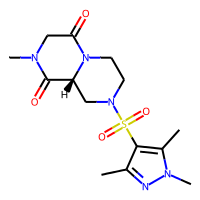
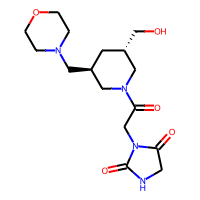
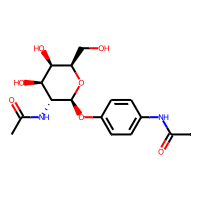
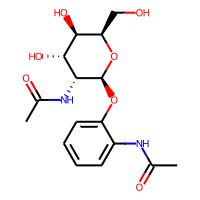
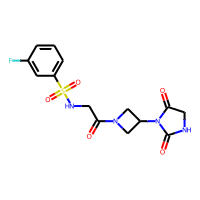
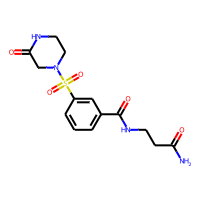
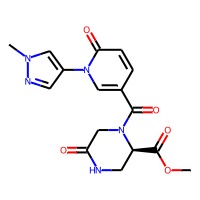
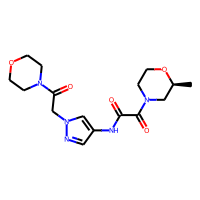
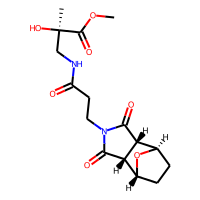
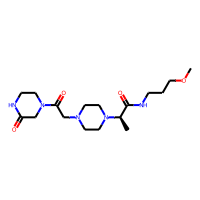

In [10]:
# df_gen_mzi

### Filter high MZs and long spectra

,smiles,canon smiles,zinc_id,Molecule,mz,intensity
0,Cc1nn(C)c(C)c1S(=O)(=O)N1CCN2C(=O)CN(C)C(=O)[C...,Cc1nn(C)c(C)c1S(=O)(=O)N1CCN2C(=O)CN(C)C(=O)[C...,65423162,,"[33, 34, 38, 39, 40, 41, 42, 43, 44, 45, 48, 5...","[0.04, 0.04, 0.01, 0.18, 0.23, 0.32, 1.0, 0.17..."
2,CC(=O)Nc1ccc(O[C@@H]2O[C@H](CO)[C@H](O)[C@H](O...,CC(=O)Nc1ccc(O[C@@H]2O[C@H](CO)[C@H](O)[C@H](O...,239433518,,"[14, 15, 16, 17, 18, 19, 25, 26, 27, 28, 29, 3...","[0.04, 0.06, 0.03, 0.05, 0.06, 0.0, 0.04, 0.09..."
4,O=C(CNS(=O)(=O)c1cccc(F)c1)N1CC(N2C(=O)CNC2=O)C1,O=C(CNS(=O)(=O)c1cccc(F)c1)N1CC(N2C(=O)CNC2=O)C1,253471034,,"[33, 38, 39, 40, 41, 42, 43, 44, 45, 48, 50, 5...","[0.05, 0.0, 0.16, 0.12, 0.21, 0.36, 0.1, 0.21,..."
5,C[C@H](C(=O)NC(=O)NC1CC1)N1CCN(C(=O)CN2CCOCC2)CC1,C[C@H](C(=O)NC(=O)NC1CC1)N1CCN(C(=O)CN2CCOCC2)CC1,25319466,,"[33, 34, 36, 38, 39, 40, 41, 42, 43, 44, 45, 5...","[0.02, 0.01, 0.03, 0.01, 0.11, 0.1, 0.29, 0.34..."
6,CN1CC(=O)N(CC(=O)NC[C@@H]2CCN(c3cnn(C)c(=O)c3)...,CN1CC(=O)N(CC(=O)NC[C@@H]2CCN(c3cnn(C)c(=O)c3)...,77470732,,"[33, 37, 38, 39, 40, 41, 42, 43, 44, 45, 50, 5...","[0.05, 0.01, 0.09, 0.41, 0.3, 0.64, 0.69, 0.46..."
...,...,...,...,...,...,...
9994,CCOC(=O)CNC(=O)[C@@H]1COCCN1C[C@H](O)COC1CCOCC1,CCOC(=O)CNC(=O)[C@@H]1COCCN1C[C@H](O)COC1CCOCC1,444605211,,"[27, 28, 29, 30, 31, 33, 39, 40, 41, 42, 43, 4...","[0.25, 0.11, 0.48, 0.54, 0.23, 0.04, 0.37, 0.1..."
9995,NC(=O)CCNC(=O)c1cccc(S(=O)(=O)N2CCNC(=O)C2)c1,NC(=O)CCNC(=O)c1cccc(S(=O)(=O)N2CCNC(=O)C2)c1,465135474,,"[33, 34, 38, 39, 40, 41, 42, 43, 44, 45, 46, 4...","[0.04, 0.01, 0.06, 0.23, 0.14, 0.23, 0.82, 0.5..."
9996,COC(=O)[C@H]1CNC(=O)CN1C(=O)c1ccc(=O)n(-c2cnn(...,COC(=O)[C@H]1CNC(=O)CN1C(=O)c1ccc(=O)n(-c2cnn(...,468641331,,"[33, 38, 39, 40, 41, 42, 43, 44, 45, 50, 51, 5...","[0.08, 0.15, 0.71, 0.35, 0.43, 0.74, 0.11, 0.0..."
9997,C[C@H]1CN(C(=O)C(=O)Nc2cnn(CC(=O)N3CCOCC3)c2)CCO1,C[C@H]1CN(C(=O)C(=O)Nc2cnn(CC(=O)N3CCOCC3)c2)CCO1,485104689,,"[33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 4...","[0.06, 0.02, 0.02, 0.08, 0.15, 0.38, 0.28, 0.4..."

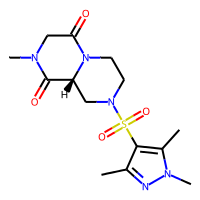
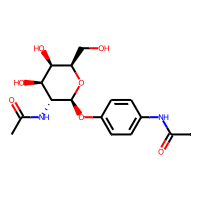
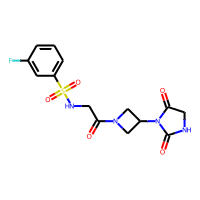
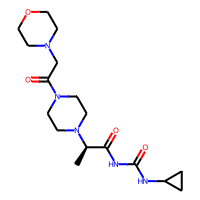
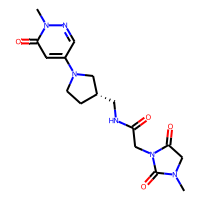
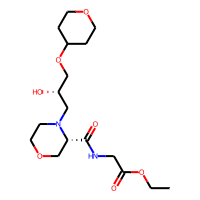
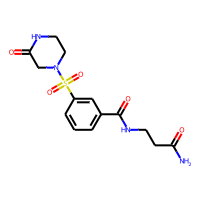
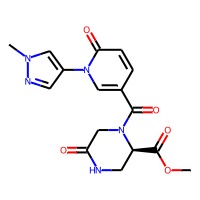
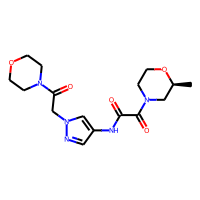
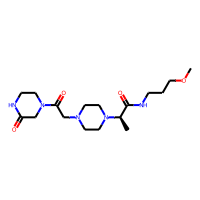

In [28]:
df_filter1.loc[[len(x) <= 180 for x in df_gen_mzi["mz"]]]

In [11]:
# LEN STATISTICS
from collections import Counter
from matplotlib import pyplot as plt
lens = [len(x) for x in df_filter1["mz"]]
c = Counter(lens)
sc = sorted(c.items(), key=lambda x: x[0])
xx = [x for x,y in sc]
yy = [y for x,y in sc]
plt.bar(xx, yy)
plt.show()
################

NameError: name 'df_filter1' is not defined

In [77]:
# filteing high MZs
max_mz = 499
df_filter1 = df_gen_mzi.loc[[x[-1]<=max_mz for x in df_gen_mzi["mz"]]]

In [78]:
# filtering long spectra
max_len = 200
df_filter2 = df_filter1.loc[[len(x) <= max_len for x in df_gen_mzi["mz"]]]

,smiles,canon smiles,zinc_id,Molecule,mz,intensity
0,Cc1nn(C)c(C)c1S(=O)(=O)N1CCN2C(=O)CN(C)C(=O)[C...,Cc1nn(C)c(C)c1S(=O)(=O)N1CCN2C(=O)CN(C)C(=O)[C...,65423162,,"[33, 34, 38, 39, 40, 41, 42, 43, 44, 45, 48, 5...","[0.04, 0.04, 0.01, 0.18, 0.23, 0.32, 1.0, 0.17..."
1,O=C(CN1C(=O)CNC1=O)N1C[C@@H](CO)C[C@H](CN2CCOC...,O=C(CN1C(=O)CNC1=O)N1C[C@@H](CO)C[C@H](CN2CCOC...,91985397,,"[2, 30, 33, 34, 36, 38, 39, 40, 41, 42, 43, 44...","[0.0, 0.02, 0.05, 0.03, 0.04, 0.03, 0.16, 0.12..."
2,CC(=O)Nc1ccc(O[C@@H]2O[C@H](CO)[C@H](O)[C@H](O...,CC(=O)Nc1ccc(O[C@@H]2O[C@H](CO)[C@H](O)[C@H](O...,239433518,,"[14, 15, 16, 17, 18, 19, 25, 26, 27, 28, 29, 3...","[0.04, 0.06, 0.03, 0.05, 0.06, 0.0, 0.04, 0.09..."
3,CC(=O)Nc1ccccc1O[C@@H]1O[C@H](CO)[C@H](O)[C@@H...,CC(=O)Nc1ccccc1O[C@@H]1O[C@H](CO)[C@H](O)[C@@H...,245377209,,"[14, 15, 16, 17, 18, 19, 25, 26, 27, 28, 29, 3...","[0.04, 0.08, 0.01, 0.05, 0.06, 0.03, 0.03, 0.0..."
4,O=C(CNS(=O)(=O)c1cccc(F)c1)N1CC(N2C(=O)CNC2=O)C1,O=C(CNS(=O)(=O)c1cccc(F)c1)N1CC(N2C(=O)CNC2=O)C1,253471034,,"[33, 38, 39, 40, 41, 42, 43, 44, 45, 48, 50, 5...","[0.05, 0.0, 0.16, 0.12, 0.21, 0.36, 0.1, 0.21,..."
...,...,...,...,...,...,...
9994,CCOC(=O)CNC(=O)[C@@H]1COCCN1C[C@H](O)COC1CCOCC1,CCOC(=O)CNC(=O)[C@@H]1COCCN1C[C@H](O)COC1CCOCC1,444605211,,"[27, 28, 29, 30, 31, 33, 39, 40, 41, 42, 43, 4...","[0.25, 0.11, 0.48, 0.54, 0.23, 0.04, 0.37, 0.1..."
9995,NC(=O)CCNC(=O)c1cccc(S(=O)(=O)N2CCNC(=O)C2)c1,NC(=O)CCNC(=O)c1cccc(S(=O)(=O)N2CCNC(=O)C2)c1,465135474,,"[33, 34, 38, 39, 40, 41, 42, 43, 44, 45, 46, 4...","[0.04, 0.01, 0.06, 0.23, 0.14, 0.23, 0.82, 0.5..."
9996,COC(=O)[C@H]1CNC(=O)CN1C(=O)c1ccc(=O)n(-c2cnn(...,COC(=O)[C@H]1CNC(=O)CN1C(=O)c1ccc(=O)n(-c2cnn(...,468641331,,"[33, 38, 39, 40, 41, 42, 43, 44, 45, 50, 51, 5...","[0.08, 0.15, 0.71, 0.35, 0.43, 0.74, 0.11, 0.0..."
9997,C[C@H]1CN(C(=O)C(=O)Nc2cnn(CC(=O)N3CCOCC3)c2)CCO1,C[C@H]1CN(C(=O)C(=O)Nc2cnn(CC(=O)N3CCOCC3)c2)CCO1,485104689,,"[33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 4...","[0.06, 0.02, 0.02, 0.08, 0.15, 0.38, 0.28, 0.4..."

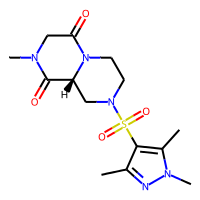
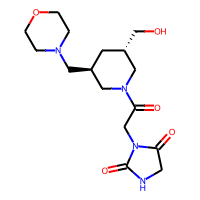
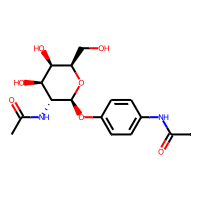
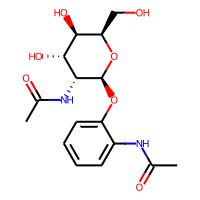
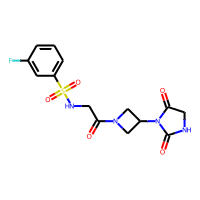
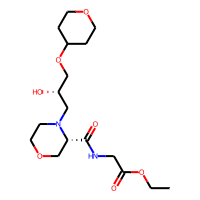
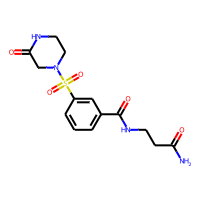
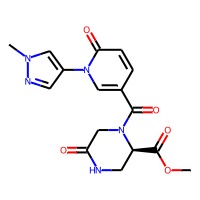
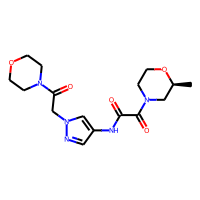
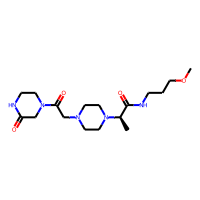

In [81]:
df_filter2

In [90]:
df_test = df_filter2[["zinc_id", "canon smiles", "mz", "intensity"]]

In [91]:
# df_test

,zinc_id,canon smiles,mz,intensity
0,65423162,Cc1nn(C)c(C)c1S(=O)(=O)N1CCN2C(=O)CN(C)C(=O)[C...,"[33, 34, 38, 39, 40, 41, 42, 43, 44, 45, 48, 5...","[0.04, 0.04, 0.01, 0.18, 0.23, 0.32, 1.0, 0.17..."
1,91985397,O=C(CN1C(=O)CNC1=O)N1C[C@@H](CO)C[C@H](CN2CCOC...,"[2, 30, 33, 34, 36, 38, 39, 40, 41, 42, 43, 44...","[0.0, 0.02, 0.05, 0.03, 0.04, 0.03, 0.16, 0.12..."
2,239433518,CC(=O)Nc1ccc(O[C@@H]2O[C@H](CO)[C@H](O)[C@H](O...,"[14, 15, 16, 17, 18, 19, 25, 26, 27, 28, 29, 3...","[0.04, 0.06, 0.03, 0.05, 0.06, 0.0, 0.04, 0.09..."
3,245377209,CC(=O)Nc1ccccc1O[C@@H]1O[C@H](CO)[C@H](O)[C@@H...,"[14, 15, 16, 17, 18, 19, 25, 26, 27, 28, 29, 3...","[0.04, 0.08, 0.01, 0.05, 0.06, 0.03, 0.03, 0.0..."
4,253471034,O=C(CNS(=O)(=O)c1cccc(F)c1)N1CC(N2C(=O)CNC2=O)C1,"[33, 38, 39, 40, 41, 42, 43, 44, 45, 48, 50, 5...","[0.05, 0.0, 0.16, 0.12, 0.21, 0.36, 0.1, 0.21,..."
...,...,...,...,...
9994,444605211,CCOC(=O)CNC(=O)[C@@H]1COCCN1C[C@H](O)COC1CCOCC1,"[27, 28, 29, 30, 31, 33, 39, 40, 41, 42, 43, 4...","[0.25, 0.11, 0.48, 0.54, 0.23, 0.04, 0.37, 0.1..."
9995,465135474,NC(=O)CCNC(=O)c1cccc(S(=O)(=O)N2CCNC(=O)C2)c1,"[33, 34, 38, 39, 40, 41, 42, 43, 44, 45, 46, 4...","[0.04, 0.01, 0.06, 0.23, 0.14, 0.23, 0.82, 0.5..."
9996,468641331,COC(=O)[C@H]1CNC(=O)CN1C(=O)c1ccc(=O)n(-c2cnn(...,"[33, 38, 39, 40, 41, 42, 43, 44, 45, 50, 51, 5...","[0.08, 0.15, 0.71, 0.35, 0.43, 0.74, 0.11, 0.0..."
9997,485104689,C[C@H]1CN(C(=O)C(=O)Nc2cnn(CC(=O)N3CCOCC3)c2)CCO1,"[33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 4...","[0.06, 0.02, 0.02, 0.08, 0.15, 0.38, 0.28, 0.4..."
